In [8]:
%%capture --no-stderr
# %pip install -U langchain langchain_community pypdf sentence_transformers chromadb

In [9]:
import langchain, langchain_community, pypdf, sentence_transformers, chromadb

for module in (langchain, langchain_community, pypdf, sentence_transformers, chromadb):
    print(f"{module.__name__:<30}{module.__version__}")

d:\Anaconda\envs\gold-yolo\lib\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4
d:\Anaconda\envs\gold-yolo\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


langchain                     0.2.8
langchain_community           0.2.7
pypdf                         4.3.0
sentence_transformers         3.1.0
chromadb                      0.4.15


In [10]:
import os
import pandas as pd

from langchain_community.vectorstores import Chroma

In [11]:
# 如果已经下载到本地，可以替换为本地路径
# EMBEDDING_MODEL_PATH = 'BAAI/bge-large-zh-v1.5'
EMBEDDING_MODEL_PATH = 'BAAI/bge-large-en-v1.5'
dt = '20240929'
version = 'baseline'

# output_dir = os.path.join('my_outputs', f'{version}_{dt}')
output_dir = r''

# 文档处理

In [12]:
from langchain_community.document_loaders import PyPDFLoader

## 文档加载

In [13]:
loader = PyPDFLoader("data_test/GeoChat.pdf")
documents = loader.load()

In [14]:
qa_df = pd.read_excel(os.path.join(output_dir, 'question_answer.xlsx'))

## 文档切分

In [15]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [18]:
# splitted_docs = split_docs(documents, os.path.join(output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)
splitted_docs = split_docs(documents, os.path.join(output_dir, 'qqq.pkl'), chunk_size=500, chunk_overlap=50)

In [13]:
splitted_docs
# len(splitted_docs)

[Document(metadata={'source': './data_test/GeoChat.pdf', 'page': 0, 'uuid': '805948dc-9161-4357-b2b7-bb88784386f5'}, page_content='GeoChat\n : Grounded Large Vision-Language Model for Remote Sensing\nKartik Kuckreja1, 2* Muhammad Sohail Danish1*Muzammal Naseer1\nAbhijit Das2Salman Khan1, 3Fahad Shahbaz Khan1, 4\n1Mohamed bin Zayed University of AI,2Birla Institute of Technology & Science, Hyderabad\n3Australian National University,4Link ¨oping University\nkartik.kuckreja@mbzuai.ac.ae, muhammad.sohail@mbzuai.ac.ae\nAbstract\nRecent advancements in Large Vision-Language Mod-\nels (VLMs) have shown great promise in natural image do-'),
 Document(metadata={'source': './data_test/GeoChat.pdf', 'page': 0, 'uuid': 'c2fc0cac-d021-4507-aa26-3d023e74b5e1'}, page_content='mains, allowing users to hold a dialogue about given vi-\nsual content. However, such general-domain VLMs perform\npoorly for Remote Sensing (RS) scenarios, leading to inac-\ncurate or fabricated information when presented with 

## 向量化

In [14]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

embeddings = HuggingFaceBgeEmbeddings(
    model_name=EMBEDDING_MODEL_PATH,
    model_kwargs={'device': device},
    encode_kwargs={'normalize_embeddings': True}
)

device: cuda


In [15]:
from tqdm.auto import tqdm

def get_vector_db(docs, store_path, force_rebuild=False):
    if not os.path.exists(store_path):
        force_rebuild = True

    if force_rebuild:
        vector_db = Chroma.from_documents(
            docs,
            embedding=embeddings,
            persist_directory=store_path
        )
    else:
        vector_db = Chroma(
            persist_directory=store_path,
            embedding_function=embeddings
        )
    return vector_db

In [16]:
vector_db = get_vector_db(splitted_docs, store_path=os.path.join(output_dir, 'chromadb', 'bge_large_v1.5'))

# 检索

In [17]:
def retrieve(vector_db, query: str, k=5):
    return vector_db.similarity_search(query, k=k)

## 计算检索准确率

In [18]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [19]:
len(test_df)

100

In [20]:
top_k_arr = list(range(1, 9))
hit_stat_data = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    question = row['question']
    true_uuid = row['uuid']
    chunks = retrieve(vector_db, question, k=max(top_k_arr))
    retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

    for k in top_k_arr:
        hit_stat_data.append({
            'question': question,
            'top_k': k,
            'hit': int(true_uuid in retrieved_uuids[:k])
        })

100%|██████████| 100/100 [00:06<00:00, 15.87it/s]


In [21]:
chunks

[Document(metadata={'page': 8, 'source': './data_test/GeoChat.pdf', 'uuid': '4fb0f285-bf87-4329-af36-26198b987bc8'}, page_content='Xiang Li. Rsgpt: A remote sensing vision language modeland benchmark. arXiv preprint arXiv:2307.15266 , 2023. 1,\n2, 7, 8\n[13] Bo Li, Yuanhan Zhang, Liangyu Chen, Jinghao Wang,\nJingkang Yang, and Ziwei Liu. Otter: A multi-modal\nmodel with in-context instruction tuning. arXiv preprint\narXiv:2305.03726 , 2023. 2\n[14] Chunyuan Li, Cliff Wong, Sheng Zhang, Naoto Usuyama,\nHaotian Liu, Jianwei Yang, Tristan Naumann, Hoifung Poon,\nand Jianfeng Gao. Llava-med: Training a large language-'),
 Document(metadata={'page': 9, 'source': './data_test/GeoChat.pdf', 'uuid': '4dbd5e8d-b98a-403f-a776-1206374f67ae'}, page_content='IEEE Transactions on Geoscience and Remote Sensing , 60:\n1–11, 2022. 2, 7\n[40] Yang Zhan, Zhitong Xiong, and Yuan Yuan. Rsvg: Exploring\ndata and models for visual grounding on remote sensing data.\nIEEE Transactions on Geoscience and Remote 

In [22]:
hit_stat_df = pd.DataFrame(hit_stat_data)

In [23]:
hit_stat_df.sample(5)

,question,top_k,hit
534,What is the distribution of RSVQA-LR [20] for ...,7,1
591,What kind of remote sensing model is GeoChat?,8,1
500,What is the size of each image in the UCMerced...,5,1
415,What are the attributes that may be absent in ...,8,0
653,Who are the authors of the LoRA paper?,6,1


In [24]:
%pip install seaborn

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [25]:
import seaborn as sns

In [26]:
hit_stat_df.groupby('top_k')['hit'].mean().reset_index()

,top_k,hit
0,1,0.42
1,2,0.56
2,3,0.62
3,4,0.65
4,5,0.71
5,6,0.73
6,7,0.74
7,8,0.74


<Axes: xlabel='top_k', ylabel='hit'>

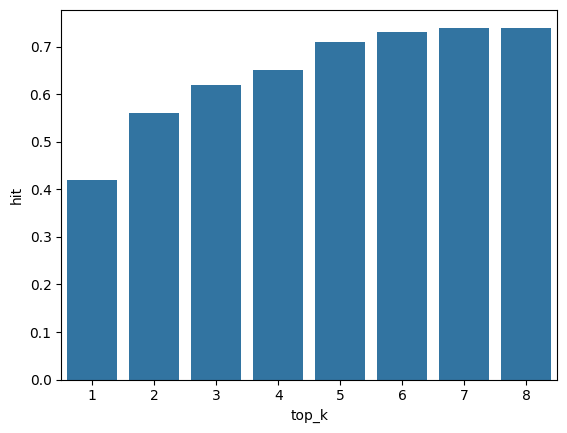

In [27]:
sns.barplot(x='top_k', y='hit', data=hit_stat_df.groupby('top_k')['hit'].mean().reset_index())

# 问答

In [28]:
## 使用LCEL

In [29]:
# !pip install langchain
# !pip install ollama
# !ollama serve
# !ollama pull qwen2:7b-instruct

In [30]:
# !ollama serve

In [31]:
# !ollama pull qwen2:7b-instruct
# !pip install langchain==0.2.10

### 流式处理

In [7]:
from langchain.llms import Ollama
# export OLLAMA_FLASH_ATTENTION=1
llm = Ollama(
    model='qwen2:7b-instruct',
    base_url="http://localhost:11434",
)
print(llm.invoke('你是谁？'))
# 30s cpu  3.2s gpu

我是阿里云开发的一款超大规模语言模型，我叫通义千问。作为一个预训练语言模型，我的主要能力是生成与给定词语相关的高质量文本。我可以回答各种问题、提供代码实现、给出创意提案、进行翻译、总结文本、分析情绪、提供建议等等。有什么我能帮助你解答的问题吗？


In [32]:
from langchain.llms import Ollama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

llm = Ollama(
    model='qwen2:7b-instruct',
    base_url="http://localhost:11434",
)

# prompt_tmpl = """
# 你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
# 你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
# 回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
# 已知信息：
# <<<<context>>>
# {context}
# <<<</context>>>

# 问题：{question}
# 请回答：
# """
prompt_tmpl = """
You are a remote sensing expert who is good at analyzing and reasoning about problems based on the information fragments obtained.
Your task is to answer questions based on the information fragments obtained (the content between <<<<context>>><<<</context>>>).
Keep your answers concise, do not repeat the question, do not add descriptive explanations and anything irrelevant to the answer.
Known information:
<<<<context>>>
{context}
<<<</context>>>

Question: {question}
Please answer:
"""
prompt = PromptTemplate.from_template(prompt_tmpl)
retriever = vector_db.as_retriever(search_kwargs={'k': 4})

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

for chunk in rag_chain.stream("What makes it hard for the models to align their behavior with user queries?"):
    print(chunk, end="", flush=True)

The lack of domain knowledge in remote sensing tasks makes it hard for models like MiniGPT-4-v2 to align their behavior with user queries.

### 非流式输出

In [33]:
# print(rag_chain.invoke('2023年10月美国ISM制造业PMI指数较上月有何变化？'))
print(rag_chain.invoke('What makes it hard for the models to align their behavior with user queries?'))

Lack of domain knowledge specific to remote sensing tasks.


## 流程拆解

In [34]:
llm = Ollama(
    model='qwen2:7b-instruct',
    base_url="http://localhost:11434"
)

In [35]:
llm.invoke('你是谁')

'我是阿里云开发的一款超大规模语言模型，我叫通义千问。作为一个预训练语言模型，我的目标是生成与给定prompt相关的、人类高质量的回应，从而帮助用户获得有用的信息或娱乐体验。如果您有任何问题或需要帮助，请随时告诉我！'

In [69]:
def rag(query, n_chunks=5):
    prompt_tmpl = """
You are a remote sensing expert who is good at analyzing and reasoning about problems based on the information fragments obtained.
Your task is to answer questions based on the information fragments obtained (the content between <<<<context>>><<<</context>>>).
Keep your answers concise, do not repeat the question, do not add descriptive explanations and anything irrelevant to the answer.
Known information:
<<<<context>>>
{context}
<<<</context>>>

Question: {question}
Please answer:
""".strip()

    chunks = retrieve(vector_db, query, k=n_chunks)
    prompt = prompt_tmpl.replace('{context}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{question}', query)

    return llm(prompt), [doc.page_content for doc in chunks]

In [71]:
question

'What abilities of VLMs are particularly noteworthy according to the text?'

In [72]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']]

answer_dict = {}

In [75]:
for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
    uuid = row['uuid']
    question = row['question']
    answer, context = rag(question, n_chunks=4)
    answer_dict[question] = {
        'uuid': uuid,
        'ref_answer': row['answer'],
        'gen_answer': answer,
        'context': context
    }

100%|██████████| 100/100 [06:51<00:00,  4.11s/it]


In [76]:
answer_dict

{'What is proposed to address the limitations mentioned?': {'uuid': '37163d64-7378-4168-9998-b89240a20c84',
  'ref_answer': 'GeoChat, the first versatile remote sensing VLM (Vision Language Model) that offers multitask conversational capabilities with high-resolution RS images',
  'gen_answer': 'Bi-modal transformer-based approach',
  'context': ['model cannot perform object grounding or accept regionData Size Response formatting prompts\nDetailed Description 30k Describe the image in detail.\nMulti-Round Conversation 65k -\nComplex Questions 10k -\nRSVQA-LRBEN[20] 56k Answer the question using a single word or phrase.\nNWPU-RESISC-45[5] 31.5k\nFloodnet[25] 4k\nGrounding Description 25k [grounding] Describe the image in detail.\nRegion Captioning 40k [identify] {bxleft, bytop, bxright, bybottom|θ}',
   'References\n[1] Jinze Bai, Shuai Bai, Shusheng Yang, Shijie Wang, Sinan\nTan, Peng Wang, Junyang Lin, Chang Zhou, and Jingren\nZhou. Qwen-vl: A frontier large vision-language model with

In [78]:
prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
prediction_df.loc[:, 'context'] = prediction_df['question'].apply(lambda q: answer_dict[q]['context'])

In [80]:
prediction_df.sample(5)

,uuid,question,qa_type,answer,gen_answer,context
463,58eff65a-541e-4bf4-8074-b921545dd641,"Overall, the model performance is low on small...",detailed,Model performance is generally low on small ob...,Our model works better on medium size images c...,[and MiniGPT-4-v2 [4] on the proposed benchmar...
225,ffb10c2c-e465-4e41-9e07-279e85b62f9b,Is the language model used in GeoChat open sou...,detailed,"Yes, the language model used in GeoChat is ope...",No information about the openness of the langu...,[language model - GeoChat. Our LoRA [11] fine-...
179,faa82d57-2e4c-4ade-8839-63cd3c9bb14f,What interval are the x and y coordinates norm...,detailed,The x and y coordinates are normalised within ...,The x and y coordinates are normalised within ...,"[normalised within the interval [0, 100] are u..."
185,7a2d75df-ef26-44aa-929a-249cd555b9d1,What is being interpolated in the transformer-...,detailed,The positional encoding is being interpolated ...,Positional encoding.,"[small objects and object details), we interpo..."
542,b75373ce-9d75-4d18-aaaf-10589779bedf,In what year was the 'Visual instruction tunin...,detailed,2023,2023,[vision-language supervision. International Jo...
